In [1]:
from codey_functions import *
import warnings
warnings.filterwarnings('ignore')

# Data Analysis

In [2]:
dunky_df = pd.read_csv('datasets/dunking-data.csv')
dunky_df = washburn_eqn(dunky_df)
dunky_df.head()

,gamma,phi,eta,L,t,biscuit,L_squared,cos(phi),1/cos(phi),1/gamma,1/t,washburn_eqn
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,0.000125,0.235556,4.245272,13.532400,0.051647,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,0.000035,0.093900,10.649644,12.353885,0.084370,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,0.000086,0.093518,10.693131,11.440614,0.040333,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,0.000014,0.068741,14.547441,14.125696,0.061377,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,0.000005,0.022520,44.404298,16.972899,0.073194,5.814437e-07


In [3]:
scatter_plot_3D(dunky_df['L'], dunky_df['cos(phi)'], dunky_df['washburn_eqn'], dunky_df['washburn_eqn'], 'L / m', 'cos(phi)', 'Average Pore Radius / m', -2.5,-0.75,0.5)

Really cool and funky lets see more information with a pair plot.

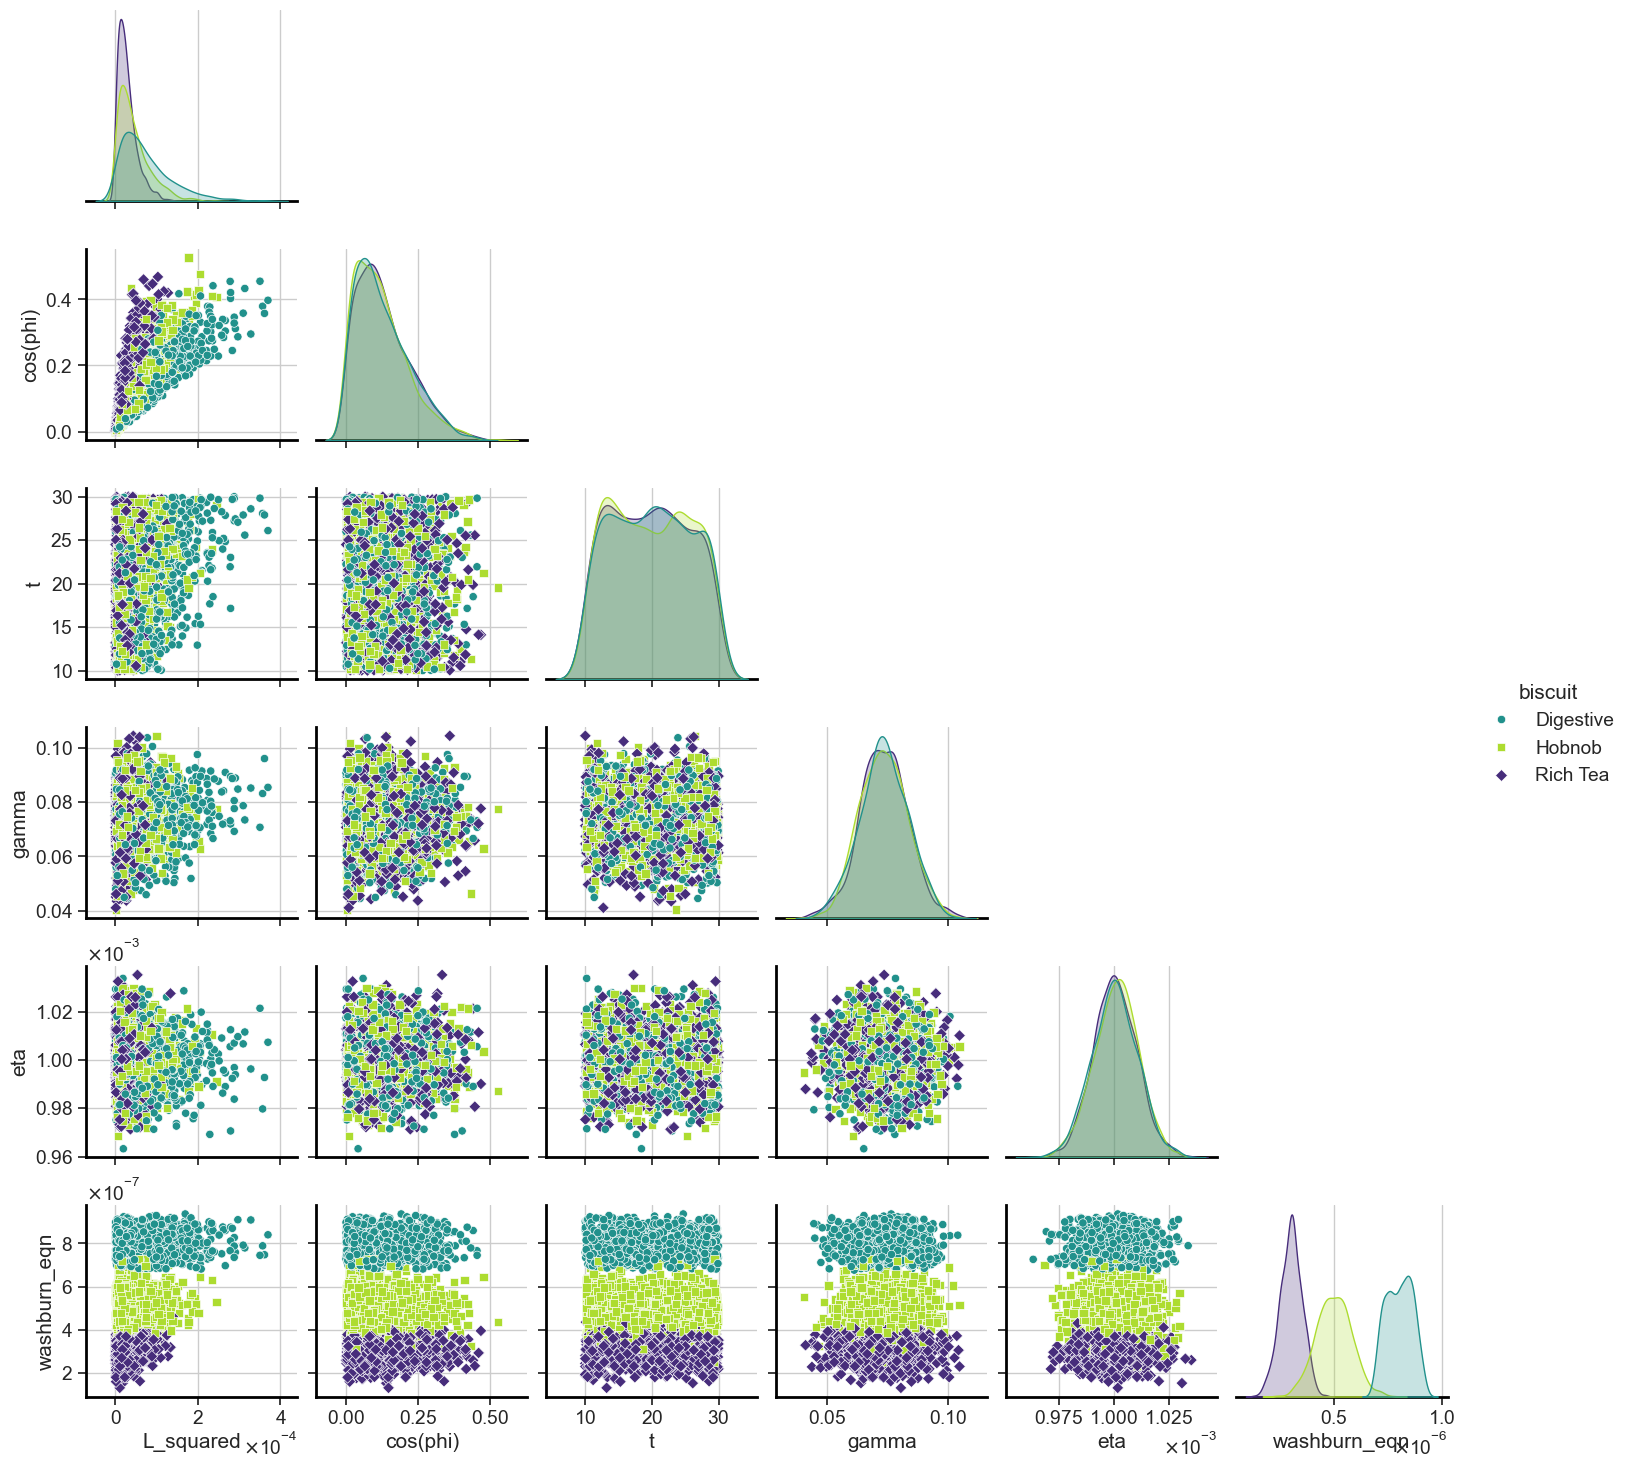

In [4]:
sns.pairplot(dunky_df[["L_squared", "cos(phi)", "t", "gamma", "eta", "washburn_eqn", "biscuit"]], diag_kind='kde', hue='biscuit', corner=True, markers=["o", "s", "D"])

In [5]:
dunky_df.groupby('biscuit').mean()

,gamma,phi,eta,L,t,L_squared,cos(phi),1/cos(phi),1/gamma,1/t,washburn_eqn
biscuit,,,,,,,,,,,
Digestive,0.073266,1.442632,0.001000,0.007864,19.960615,0.000075,0.127117,42.771629,13.918771,0.055119,8.021261e-07
Hobnob,0.073195,1.448127,0.001001,0.006022,19.870021,0.000044,0.121672,37.290931,13.921631,0.055418,5.003074e-07
Rich Tea,0.073260,1.439174,0.001000,0.004843,19.715481,0.000028,0.130517,23.257087,13.923288,0.055743,3.020585e-07


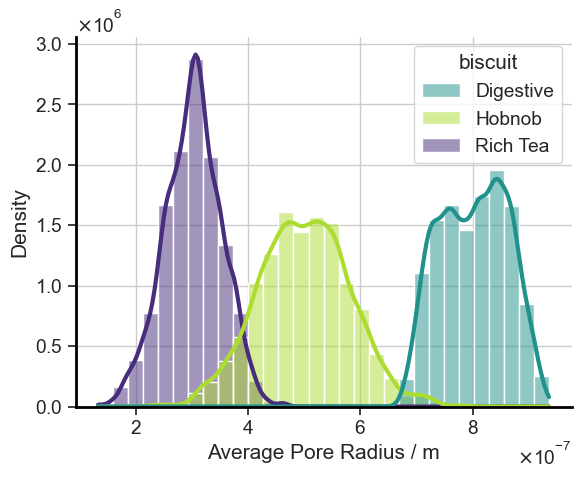

In [6]:
sns.histplot(data=dunky_df, x="washburn_eqn", kde=True, hue="biscuit", bins=30, stat='density', line_kws={'linewidth': 3}, kde_kws={'bw_adjust': 0.75})
plt.xlabel('Average Pore Radius / m')
plt.savefig('plot_images/dunky_r_hist.png', dpi=900)

Within these histograms you can see different number of modes within them, therefore taking the mean to approximate the value of r for each biscuit type would not be telling the full story. As such we need to find the peaks that these modes are at, but due to the badwidth changing the number of modes found (see interactive plots in N-modal_interactive plots) for more information.

## Finding number of Mode traces

In [7]:
bw_values = np.arange(1.1, 0.09, -0.01)
tolerance = 1e6

mode_evolutions = {}
for biscuit in dunky_df['biscuit'].unique():
    mode_evolutions[biscuit] = follow_peak_evolution(dunky_df[dunky_df['biscuit'] == biscuit]['washburn_eqn'], bw_values, tolerance)

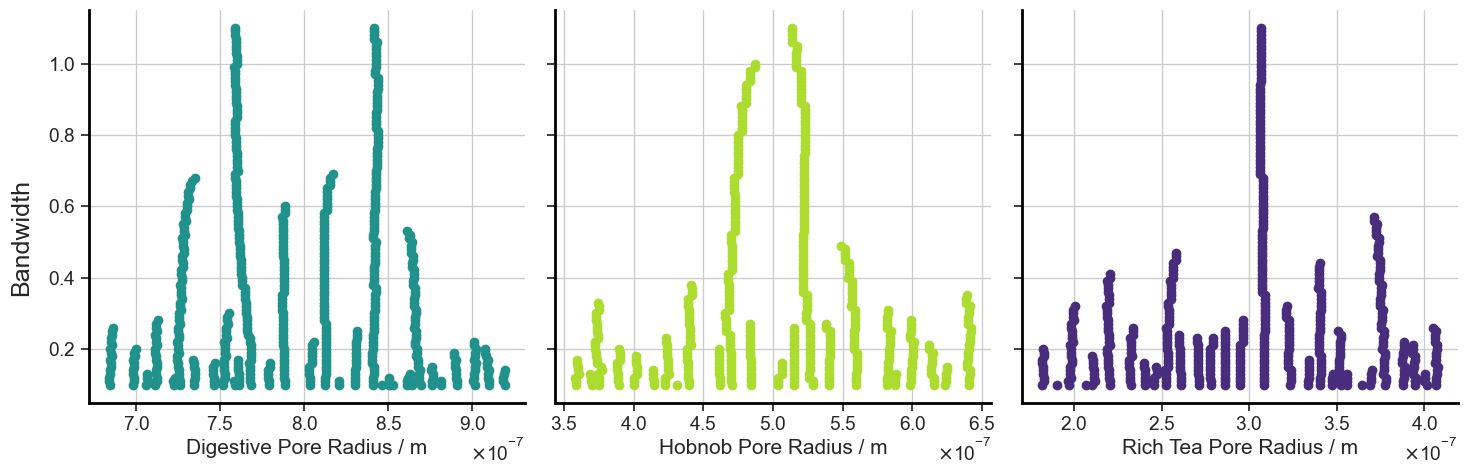

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].scatter(mode_evolutions['Digestive'][:,0], mode_evolutions['Digestive'][:,1], color=palette[0])
axs[0].set_xlabel('Digestive Pore Radius / m')

axs[1].scatter(mode_evolutions['Hobnob'][:,0], mode_evolutions['Hobnob'][:,1], color=palette[1])
axs[1].set_xlabel('Hobnob Pore Radius / m')

axs[2].scatter(mode_evolutions['Rich Tea'][:,0], mode_evolutions['Rich Tea'][:,1], color=palette[2])
axs[2].set_xlabel('Rich Tea Pore Radius / m')

fig.supylabel('Bandwidth')
plt.tight_layout()
plt.show()

From the plots above I know I want 2 mode traces for Digestives and Hobnobs but only 1 mode trace for Rich tea. From the interactive plots I know I used the rigt bandwidth choices and tolerance. The only unkown I have now is the precentage range. Which is fine.

# Mode Trace Results

In [9]:
key_values_to_quant = ['L', 't', 'phi', 'washburn_eqn']

## Digestive Biscuits

Text(0, 0.5, 'Bandwidth')

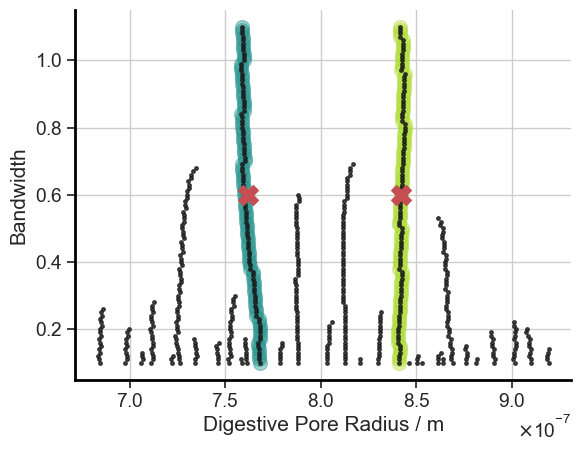

In [10]:
precentage_range = 0.005
number_of_modes = 2
datapoints = dunky_df[dunky_df['biscuit'] == 'Digestive']['washburn_eqn']

dig_trace_modes, dig_ev_mode = trace_modes(datapoints, bw_values, tolerance, precentage_range, number_of_modes)
dig_trace_centers = trace_centers(dig_trace_modes)

for key in dig_trace_modes:
    plt.scatter(dig_trace_modes[key][:,0], dig_trace_modes[key][:,1], label=key, alpha=0.4, s=100)
    
plt.scatter(dig_ev_mode[:,0], dig_ev_mode[:,1], marker='.', c='k', label='All Peaks', alpha=0.8, s=25)
plt.scatter(dig_trace_centers[:,0], dig_trace_centers[:,1], marker='X', c='r', label='Centroids', s=200)
plt.xlabel('Digestive Pore Radius / m')
plt.ylabel('Bandwidth')

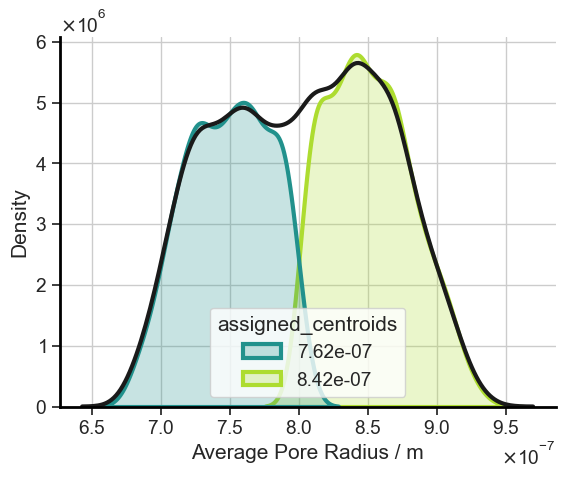

assigned_centroids
7.62e-07    0.007744
8.42e-07    0.007975
Name: L, dtype: float64


assigned_centroids
7.62e-07    20.257223
8.42e-07    19.686822
Name: t, dtype: float64


assigned_centroids
7.62e-07    1.441480
8.42e-07    1.443695
Name: phi, dtype: float64


assigned_centroids
7.62e-07    7.489360e-07
8.42e-07    8.512246e-07
Name: washburn_eqn, dtype: float64




In [11]:
centers_reshaped = dig_trace_centers[:,0].reshape(-1,1)

# Initialize k-NN model
k = number_of_modes
knn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(centers_reshaped)

# Find nearest centroids
distances, indices = knn_model.kneighbors(datapoints.values.reshape(-1,1))

# Assign data points to centroids
assigned_centroids = centers_reshaped[indices[:, 0]]

cat_assigned_centroids = np.round(assigned_centroids, 9).astype(str)

dig_df = dunky_df[dunky_df['biscuit'] == 'Digestive']

dig_df['assigned_centroids'] = cat_assigned_centroids

sns.kdeplot(data=dig_df, x="washburn_eqn", hue = 'assigned_centroids', bw_adjust=1, common_norm=True, fill=True, linewidth=3)
sns.kdeplot(data=dig_df, x="washburn_eqn", bw_adjust=0.75, common_norm=True, fill=False, linewidth=3, color='k')
plt.xlabel('Average Pore Radius / m')
plt.show()

for value in key_values_to_quant:
    print(dig_df.groupby('assigned_centroids')[value].mean())
    print('\n')

## Hobnob Biscuits

Text(0, 0.5, 'Bandwidth')

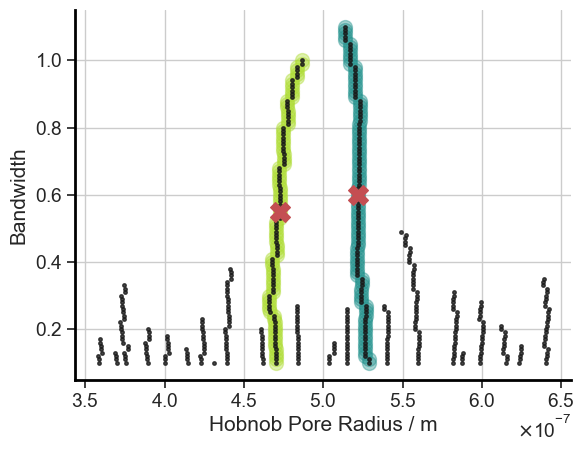

In [12]:
precentage_range = 0.009
number_of_modes = 2
datapoints = dunky_df[dunky_df['biscuit'] == 'Hobnob']['washburn_eqn']

hob_trace_modes, hob_ev_mode = trace_modes(datapoints, bw_values, tolerance, precentage_range, number_of_modes)
hob_trace_centers = trace_centers(hob_trace_modes)

for key in hob_trace_modes:
    plt.scatter(hob_trace_modes[key][:,0], hob_trace_modes[key][:,1], label=key, alpha=0.4, s=100)
    
plt.scatter(hob_ev_mode[:,0], hob_ev_mode[:,1], marker='.', c='k', label='All Peaks', alpha=0.8, s=25)
plt.scatter(hob_trace_centers[:,0], hob_trace_centers[:,1], marker='X', c='r', label='Centroids', s=200)
plt.xlabel('Hobnob Pore Radius / m')
plt.ylabel('Bandwidth')

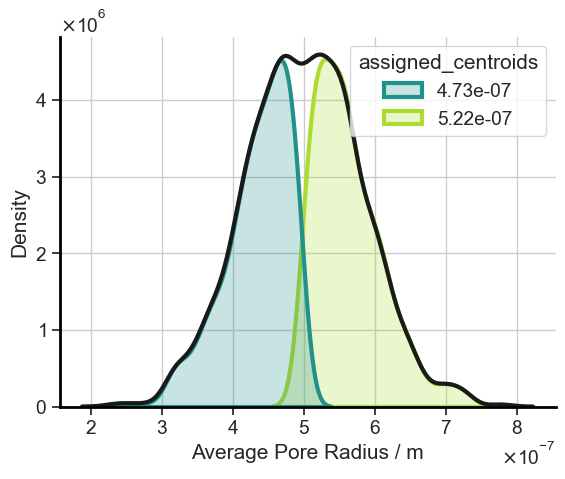

assigned_centroids
4.73e-07    0.005634
5.22e-07    0.006388
Name: L, dtype: float64


assigned_centroids
4.73e-07    19.982749
5.22e-07    19.763433
Name: t, dtype: float64


assigned_centroids
4.73e-07    1.446392
5.22e-07    1.449768
Name: phi, dtype: float64


assigned_centroids
4.73e-07    4.335972e-07
5.22e-07    5.633835e-07
Name: washburn_eqn, dtype: float64




In [13]:
centers_reshaped = hob_trace_centers[:,0].reshape(-1,1)

# Initialize k-NN model
k = number_of_modes
knn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(centers_reshaped)

# Find nearest centroids
distances, indices = knn_model.kneighbors(datapoints.values.reshape(-1,1))

# Assign data points to centroids
assigned_centroids = centers_reshaped[indices[:, 0]]

cat_assigned_centroids = np.round(assigned_centroids, 9).astype(str)

hob_df = dunky_df[dunky_df['biscuit'] == 'Hobnob']

hob_df['assigned_centroids'] = cat_assigned_centroids

sns.kdeplot(data=hob_df, x="washburn_eqn", hue = 'assigned_centroids', bw_adjust=1, common_norm=True, fill=True, linewidth=3)
sns.kdeplot(data=hob_df, x="washburn_eqn", bw_adjust=0.75, common_norm=True, fill=False, linewidth=3, color='k')
plt.xlabel('Average Pore Radius / m')
plt.show()

for value in key_values_to_quant:
    print(hob_df.groupby('assigned_centroids')[value].mean())
    print('\n')

## Rich Tea

Text(0, 0.5, 'Bandwidth')

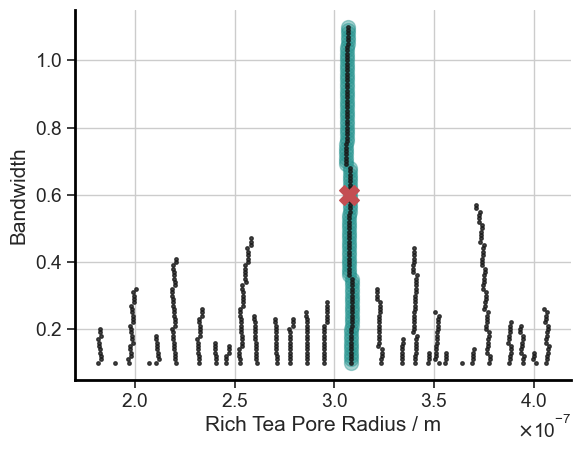

In [14]:
precentage_range = 0.009
number_of_modes = 1
datapoints = dunky_df[dunky_df['biscuit'] == 'Rich Tea']['washburn_eqn']

rich_trace_modes, rich_ev_mode = trace_modes(datapoints, bw_values, tolerance, precentage_range, number_of_modes)
rich_trace_centers = trace_centers(rich_trace_modes)

for key in rich_trace_modes:
    plt.scatter(rich_trace_modes[key][:,0], rich_trace_modes[key][:,1], label=key, alpha=0.4, s=100)
    
plt.scatter(rich_ev_mode[:,0], rich_ev_mode[:,1], marker='.', c='k', label='All Peaks', alpha=0.8, s=25)
plt.scatter(rich_trace_centers[:,0], rich_trace_centers[:,1], marker='X', c='r', label='Centroids', s=200)
plt.xlabel('Rich Tea Pore Radius / m')
plt.ylabel('Bandwidth')

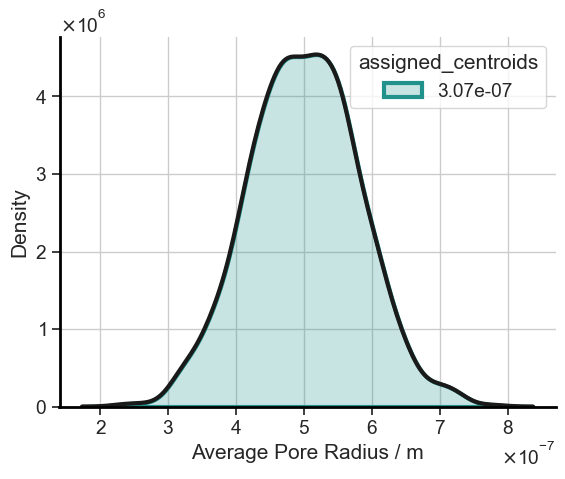

assigned_centroids
3.07e-07    0.006022
Name: L, dtype: float64


assigned_centroids
3.07e-07    19.870021
Name: t, dtype: float64


assigned_centroids
3.07e-07    1.448127
Name: phi, dtype: float64


assigned_centroids
3.07e-07    5.003074e-07
Name: washburn_eqn, dtype: float64




In [15]:
centers_reshaped = rich_trace_centers[:,0].reshape(-1,1)

# Initialize k-NN model
k = number_of_modes
knn_model = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(centers_reshaped)

# Find nearest centroids
distances, indices = knn_model.kneighbors(datapoints.values.reshape(-1,1))

# Assign data points to centroids
assigned_centroids = centers_reshaped[indices[:, 0]]

cat_assigned_centroids = np.round(assigned_centroids, 9).astype(str)

rich_df = dunky_df[dunky_df['biscuit'] == 'Hobnob']

rich_df['assigned_centroids'] = cat_assigned_centroids

sns.kdeplot(data=rich_df, x="washburn_eqn", hue = 'assigned_centroids', bw_adjust=1, common_norm=True, fill=True, linewidth=3)
sns.kdeplot(data=rich_df, x="washburn_eqn", bw_adjust=1, common_norm=True, fill=False, linewidth=3, color='k')
plt.xlabel('Average Pore Radius / m')
plt.show()

for value in key_values_to_quant:
    print(rich_df.groupby('assigned_centroids')[value].mean())
    print('\n')